<a href="https://colab.research.google.com/github/thibaudchevrier/jedha_final_project/blob/develop/notebooks/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DATASET_PATH = "/content/drive/MyDrive/Final_project/datasets"

assert os.path.exists(DATASET_PATH), "Problem with registered path"
print("Path successfully verified !!!!")

Path successfully verified !!!!


In [ ]:
from pathlib import Path
import tarfile

# Unzip all tarfiles in datasets folder if not already unzipped
for tar_file in list(Path(DATASET_PATH).rglob("*.*gz")):
    tar_file = str(tar_file)
    if not os.path.exists(tar_file.split(".")[0]):
        destination_path, _ = os.path.split(tar_file)
        file = tarfile.open(tar_file, mode="r:gz")
        file.extractall(path=destination_path)
        file.close()

In [ ]:
!pip install kaggle

In [ ]:
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/Final_project/datasets/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/Final_project/datasets/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
import time
import numpy as np 
import tensorflow as tf
import json
import matplotlib.pyplot as plt 
import pandas as pd
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Import required libraries
import os
import gc
import sys
import random
from pathlib import Path

import cv2 # CV2 for image manipulation
from tqdm import tqdm
from imgaug import augmenters as iaa
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold


# 1 - Train data import


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Final_project/datasets/imaterialist

Mounted at /content/drive
label_descriptions.json  sample_submission.csv	test  train  train.csv


In [4]:
with open('/content/drive/MyDrive/Final_project/datasets/imaterialist/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
data = pd.read_csv("/content/drive/MyDrive/Final_project/datasets/imaterialist/train.csv") 
sample_sub_df = pd.read_csv('/content/drive/MyDrive/Final_project/datasets/imaterialist/sample_submission.csv')

In [5]:
data.head()

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219


In [6]:
data["AttributesIds"] = data["AttributesIds"].apply(lambda x: [int(element) for element in str(x).split(",")] if pd.notnull(x) else x)

In [7]:
sample_sub_df.head()

,ImageId,EncodedPixels,ClassId,AttributesIds
0,003d41dd20f271d27219fe7ee6de727d,1 1,0,"111,137"
1,0046f98599f05fd7233973e430d6d04d,1 1,0,"111,137"
2,004e9e21cd1aca568a8ffc77a54638ce,1 1,0,"111,137"
3,005b37fce3c0f641d327d95dd832f51b,1 1,0,"111,137"
4,0094940c58c343b742f48ae26eb5e9fa,1 1,0,"111,137"


In [8]:
sample_sub_df["AttributesIds"] = sample_sub_df["AttributesIds"].apply(lambda x: [int(element) for element in str(x).split(",")] if pd.notnull(x) else x)

In [9]:
print(f'Shape of training dataset: {data.shape}')
print(f'Shape of testing dataset: {sample_sub_df.shape}')
print(f'# of images in training set: {data["ImageId"].nunique()}')
print(f'# of images in test set: {sample_sub_df["ImageId"].nunique()}')

Shape of training dataset: (333401, 6)
Shape of testing dataset: (3200, 4)
# of images in training set: 45623
# of images in test set: 3200


# 2 - Exploratory Data Analysis


## Image size analysis in training dataset

In [10]:
pd.DataFrame([data['Height'].describe(), data['Width'].describe()]).T.loc[['max', 'min', 'mean']]

,Height,Width
max,8688.000000,10717.00000
min,296.000000,151.00000
mean,2235.524021,1761.97925


## Details about Classes and Attributes

In [11]:
num_classes = len(label_desc['categories'])
num_attributes = len(label_desc['attributes'])
print(f'Total # of classes: {num_classes}')
print(f'Total # of attributes: {num_attributes}')

Total # of classes: 46
Total # of attributes: 294


In [12]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [13]:
pd.set_option('display.max_rows', 300)
attributes_df

,id,name,supercategory,level
0,0,classic (t-shirt),nickname,1
1,1,polo (shirt),nickname,1
2,2,undershirt,nickname,1
3,3,henley (shirt),nickname,1
4,4,ringer (t-shirt),nickname,1
5,5,raglan (t-shirt),nickname,1
6,6,rugby (shirt),nickname,1
7,7,sailor (shirt),nickname,1
8,8,crop (top),nickname,1
9,9,halter (top),nickname,1


On crée un dataset  "image_df" qui contient des id  uniques des images:

In [22]:
image_df = data.groupby('ImageId')['AttributesIds', 'ClassId'].agg(lambda x: list(x))
image_df.reset_index(inplace=True)
image_df['ImageId'] = image_df['ImageId'].astype('str')
image_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,ImageId,AttributesIds,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e,"[[115, 136, 143, 154, 230, 295, 316, 317], [11...","[6, 0, 28, 31, 32, 32, 31, 29, 4]"
1,0000fe7c9191fba733c8a69cfaf962b7,"[[190], [0, 115, 145, 146, 295, 316, 317]]","[33, 1]"
2,0002ec21ddb8477e98b2cbb87ea2e269,"[[182], [102, 128, 142, 150, 229, 295, 301, 31...","[33, 10, 23, 23]"
3,0002f5a0ebc162ecfb73e2c91e3b8f62,"[[108, 115, 119, 141, 155, 229, 286, 316, 317]...","[10, 33, 15]"
4,0004467156e47b0eb6de4aa6479cbd15,"[[115, 141, 155, 295, 305, 317], [188], [159],...","[10, 33, 31, 31, 15]"


In [15]:
categorie_names = {cat["id"]: cat["name"] for cat in label_desc['categories']}
attribute_names = {cat["id"]: cat["name"] for cat in label_desc['attributes']}

Affiche valeurs uniques des IDclasses par Image:

In [24]:
import itertools

image_df['SetClassId'] = image_df["ClassId"].apply(lambda x: set(x))
image_df['SetAttributesIds'] = image_df["AttributesIds"].apply(lambda x: [set(element) if type(element) is list else element for element in x ])
image_df.drop(['AttributesIds','ClassId'],axis=1,inplace=True)


## Plotting a few training images without any masks

**************************************************


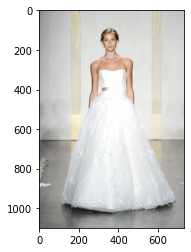

[0] neckline
[1] dress: [0] sweetheart (neckline)
[2] flower: [0] zip-up, [1] no non-textile material, [2] floor (length), [3] gown, [4] high waist, [5] symmetrical, [6] lining, [7] applique(a), [8] bell, [9] plain (pattern)
**********
**************************************************


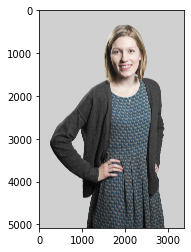

[0] neckline: [0] wrist-length, [1] dropped-shoulder sleeve
[1] dress: [0] wrist-length
[2] cardigan: [0] round (neck)
[3] sleeve: [0] zip-up, [1] no non-textile material, [2] printed, [3] pleat, [4] no waistline
**********
**************************************************


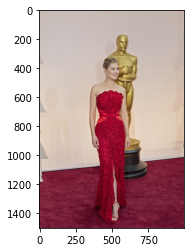

[0] neckline
[1] bead
[2] dress
[3] belt
[4] shoe
**********
**************************************************


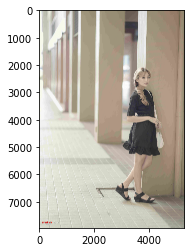

[0] neckline
[1] dress: [0] elbow-length
[2] headband, head covering, hair accessory
[3] shoe: [0] no non-textile material, [1] shirt (dress), [2] normal waist, [3] gathering, [4] mini (length), [5] trumpet, [6] plain (pattern)
[4] bag, wallet
[5] sleeve
**********
**************************************************


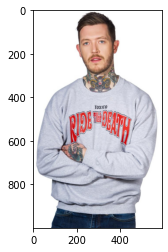

[0] top, t-shirt, sweatshirt: [0] letters, numbers, [1] no non-textile material, [2] regular (fit), [3] printed, [4] no waistline, [5] above-the-hip (length), [6] symmetrical, [7] plain (pattern)
[1] sleeve: [0] round (neck)
[2] neckline: [0] wrist-length, [1] dropped-shoulder sleeve
**********


In [29]:
for i in range(5):
    x = np.random.randint(0,len(image_df),size=(1,))[0]
    ID = image_df['ImageId'].iloc[x]
    classes = image_df['SetClassId'].iloc[x]
    attributes = image_df['SetAttributesIds'].iloc[x]
    print('*'*50)
    plt.imshow(mpimg.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{ID}.jpg'))
    plt.show()
    for j, idx in enumerate(classes):
        attribute_display = ""
        if pd.notnull(attributes[j]):
            attribute_display = ": " + ", ".join(['[{}] {}'.format(j_attr, attribute_names[idx_attr]) for j_attr, idx_attr in enumerate(attributes[j])])
        categorie_display = '[{}] {}'.format(j,categorie_names[idx])
        print(categorie_display + attribute_display)
    print('*'*10)

## Plotting a few images with given segments

In [ ]:
def create_mask(size):
    image_ids = image_df['ImageId'][:size]
    images_meta=[]

    for image_id in image_ids:
        img = mpimg.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{image_id}.jpg')
        images_meta.append({
            'image': img,
            'shape': img.shape,
            'encoded_pixels': data[data['ImageId'] == image_id]['EncodedPixels'],
            'class_ids':  data[data['ImageId'] == image_id]['ClassId']
        })

    masks = []
    for image in images_meta:
        shape = image.get('shape')
        encoded_pixels = list(image.get('encoded_pixels'))
        class_ids = list(image.get('class_ids'))
        
        # Initialize numpy array with shape same as image size
        height, width = shape[:2]
        mask = np.zeros((height, width)).reshape(-1)
        
        # Iterate over encoded pixels and create mask
        #Création d'un mask à partir de pixels encodés:
        for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
            splitted_pixels = list(map(int, pixel_str.split()))
            pixel_starts = splitted_pixels[::2]
            run_lengths = splitted_pixels[1::2]
            assert max(pixel_starts) < mask.shape[0]
            for pixel_start, run_length in zip(pixel_starts, run_lengths):
                pixel_start = int(pixel_start) - 1
                run_length = int(run_length)
                mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4
        masks.append(mask.reshape((height, width), order='F'))  # https://stackoverflow.com/questions/45973722/how-does-numpy-reshape-with-order-f-work
    return masks, images_meta

In [ ]:
def plot_segmented_images(size=12, figsize=(14, 14)):
    # First create masks from given segments
    masks, images_meta = create_mask(size)
    
    # Plot images in groups of 4 images
    n_groups = 4
    
    count = 0
    for index in range(size // 4):
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
        for row in ax:
            for col in row:
                col.imshow(images_meta[count]['image'])
                col.imshow(masks[count], alpha=0.75)
                col.axis('off')
                count += 1
        plt.show()




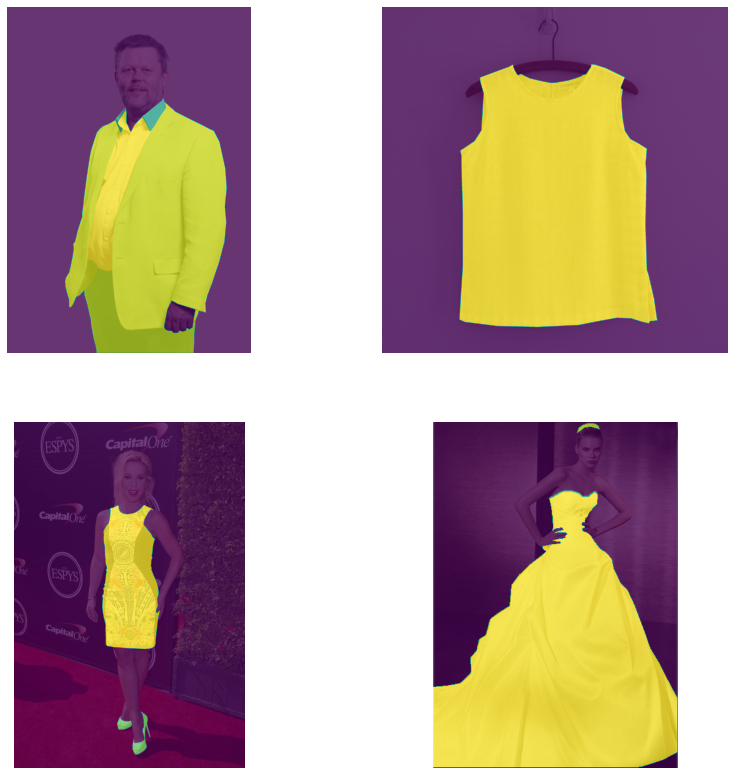

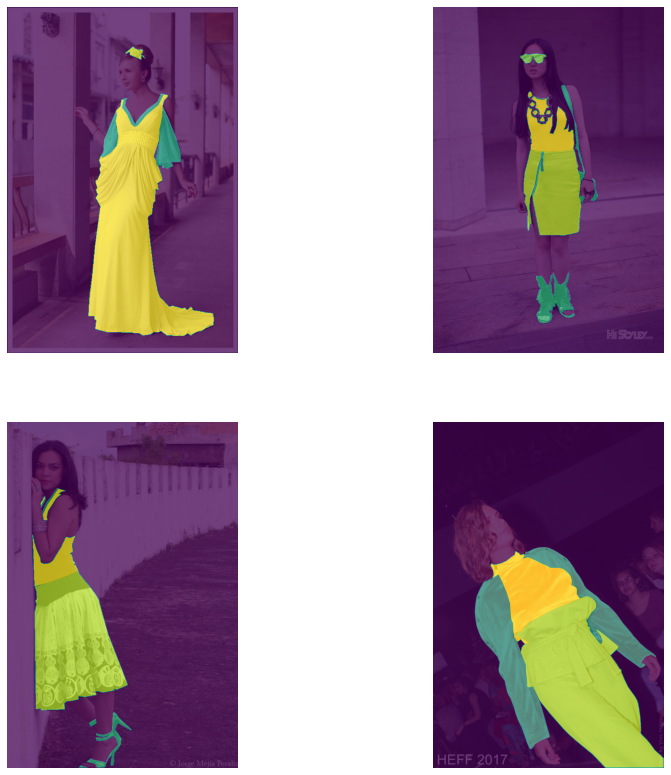

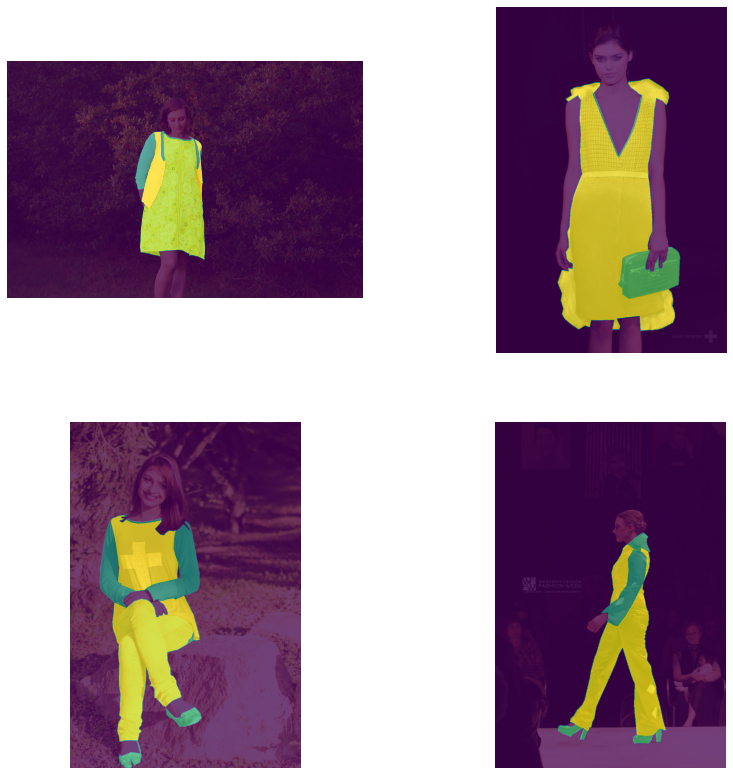

In [ ]:
plot_segmented_images()

## Analysing Categories and Attributes

In [ ]:
categories_df = pd.DataFrame(label_desc['categories'])
attributes_df = pd.DataFrame(label_desc['attributes'])
categories_df

,id,name,supercategory,level
0,0,"shirt, blouse",upperbody,2
1,1,"top, t-shirt, sweatshirt",upperbody,2
2,2,sweater,upperbody,2
3,3,cardigan,upperbody,2
4,4,jacket,upperbody,2
5,5,vest,upperbody,2
6,6,pants,lowerbody,2
7,7,shorts,lowerbody,2
8,8,skirt,lowerbody,2
9,9,coat,wholebody,2


In [ ]:
data['ClassId'] = data['ClassId'].astype('category')

In [ ]:
IMAGE_ID = '000b3ec2c6eaffb491a5abb72c2e3e26'

This image has 8 segmentes and a few attributes:

In [ ]:
# Get the an image id given in the training set for visualization
vis_df = data[data['ImageId'] == IMAGE_ID]
vis_df['ClassId'] = vis_df['ClassId'].cat.codes
vis_df = vis_df.reset_index(drop=True)
vis_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,000b3ec2c6eaffb491a5abb72c2e3e26,752989 6 755294 19 757599 31 759904 44 762209 ...,2310,1536,23,NaN
1,000b3ec2c6eaffb491a5abb72c2e3e26,1468756 2 1471067 9 1473378 15 1475689 21 1478...,2310,1536,23,NaN
2,000b3ec2c6eaffb491a5abb72c2e3e26,701292 5 703597 15 705903 25 708209 34 710515 ...,2310,1536,6,"[115, 135, 154, 230, 295, 316, 317]"
3,000b3ec2c6eaffb491a5abb72c2e3e26,458445 17 460731 51 463017 85 465303 115 46759...,2310,1536,1,"[0, 115, 136, 145, 147, 295, 314, 317]"
4,000b3ec2c6eaffb491a5abb72c2e3e26,1787118 1 1789427 1 1791735 3 1794044 3 179635...,2310,1536,32,[218]
5,000b3ec2c6eaffb491a5abb72c2e3e26,1139954 1 1142264 1 1144573 2 1146882 3 114919...,2310,1536,31,"[160, 204]"
6,000b3ec2c6eaffb491a5abb72c2e3e26,458445 17 460731 51 463017 85 465303 115 46759...,2310,1536,31,"[160, 204]"
7,000b3ec2c6eaffb491a5abb72c2e3e26,839153 2 841462 6 843771 10 846081 12 848390 1...,2310,1536,33,[190]



### Plot each segment in a separate image

In [ ]:
categories_df['name']

0                               shirt, blouse
1                    top, t-shirt, sweatshirt
2                                     sweater
3                                    cardigan
4                                      jacket
5                                        vest
6                                       pants
7                                      shorts
8                                       skirt
9                                        coat
10                                      dress
11                                   jumpsuit
12                                       cape
13                                    glasses
14                                        hat
15    headband, head covering, hair accessory
16                                        tie
17                                      glove
18                                      watch
19                                       belt
20                                 leg warmer
21                          tights

In [ ]:
segments = list(vis_df['EncodedPixels'])
class_ids = list(vis_df['ClassId'])
masks = []
for segment, class_id in zip(segments, class_ids):
    
    height = vis_df['Height'][0]
    width = vis_df['Width'][0]
    # Initialize empty mask
    mask = np.zeros((height, width)).reshape(-1)
    
    # Iterate over encoded pixels and create mask
    splitted_pixels = list(map(int, segment.split()))
    pixel_starts = splitted_pixels[::2]
    run_lengths = splitted_pixels[1::2]
    assert max(pixel_starts) < mask.shape[0]
    for pixel_start, run_length in zip(pixel_starts, run_lengths):
        pixel_start = int(pixel_start) - 1
        run_length = int(run_length)
        mask[pixel_start:pixel_start+run_length] = 255 - class_id * 4

    mask = mask.reshape((height, width), order='F')
    masks.append(mask)

[]

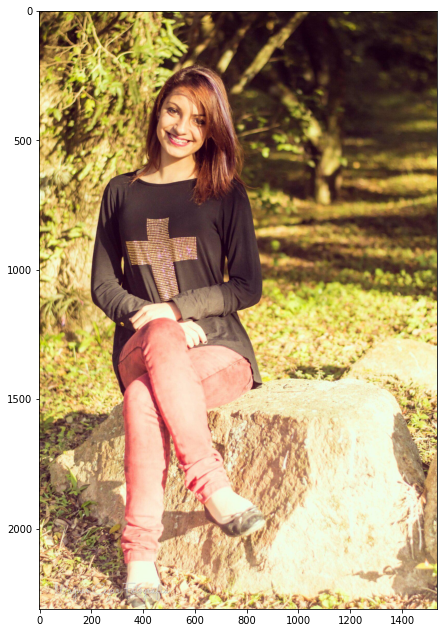

In [ ]:
plt.figure(figsize = (110,11))
image = mpimg.imread(f'/content/drive/MyDrive/Final_project/datasets/imaterialist/train/{IMAGE_ID}.jpg')
plt.grid(False)
plt.imshow(image)
plt.plot()

In [ ]:
def plot_individual_segment(*masks, image, figsize=(110, 11)):
    plt.figure(figsize = figsize)
    plt.imshow(image)
    for mask in masks:
        plt.imshow(mask, alpha=0.6)

    plt.axis('off')
    plt.show()

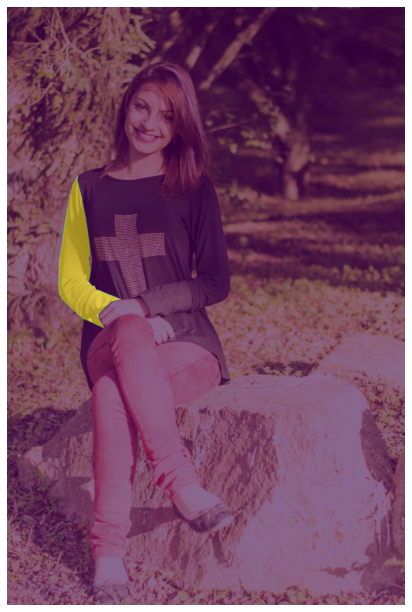

Category:  sleeve
Attributes:  wrist-length, set-in sleeve


In [ ]:
index=6 #change index  to visualize the segment

plot_individual_segment(masks[index], image=image)
print("Category: ", categories_df["name"][vis_df["ClassId"][index]])
attributes = vis_df["AttributesIds"][index]
if type(attributes) is list:
    print("Attributes: ", ", ".join([attributes_df["name"][idx] for idx in attributes]))

Some of the segments have no attributes. Let's check how many such segment exists in training dataset.

In [ ]:
print(f'Segments that do not have attributes: {data["AttributesIds"].isna().sum()/len(data) * 100} %')

Segments that do not have attributes: 38.089567817733 %


Missing values of dataset:

In [ ]:
data[['ImageId', 'EncodedPixels', 'Height', 'Width', 'ClassId']].isna().sum()

ImageId          0
EncodedPixels    0
Height           0
Width            0
ClassId          0
dtype: int64

#3 - Data preprocessing

Drop attributeIds for simplicity for now. ! DO NOT FORGET TO ADD THEM FOR MORE COMPLEXE MODEL ! 

In [ ]:
data = data.drop('AttributesIds', axis=1)

In [ ]:
image_df = data.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = data.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

#4 - Mask-RCNN modelling

Réference : https://github.com/matterport/Mask_RCNN/blob/master/samples/shapes/train_shapes.ipynb

In [ ]:
import os
from pathlib import Path
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 31.41 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/Final_project/datasets/imaterialist/')
ROOT_DIR = Path('/content/drive/MyDrive/Final_project')

In [ ]:
import sys

In [ ]:
# sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [ ]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "class"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(categories_df)  # background + 46 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = FashionConfig()
config.display()

In [ ]:
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(DATA_DIR/'train'/row.name) + '.jpg', 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def _resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

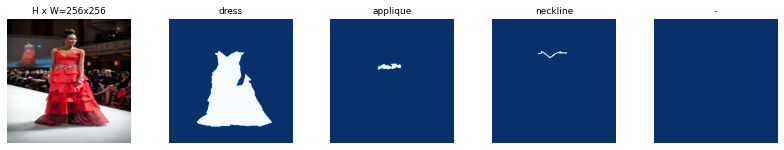

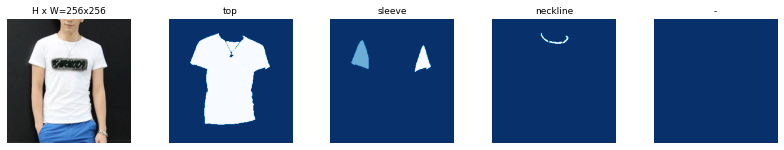

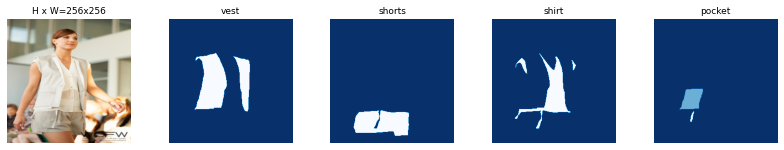

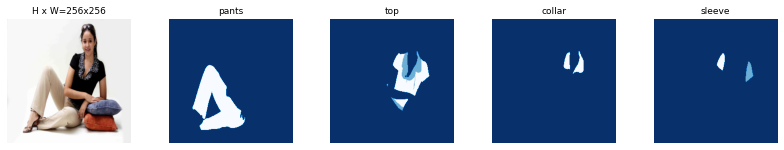

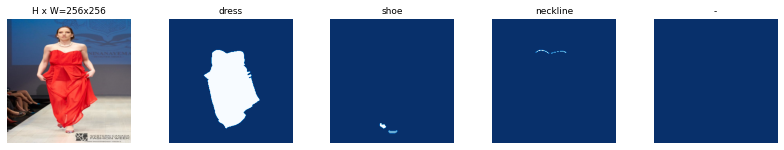

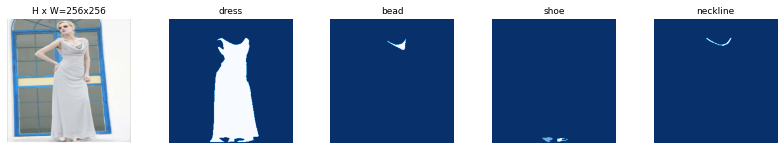

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)